In [3]:
import pandas as pd

df  =  pd.read_csv('data/agg.txt', sep = '\t')
df.head()

# Load the dataset properly, using pandas because I've used that outside of class more than polars.
# Running `df.head()` to make sure everything looks right.

,group,study.quarter,actor,target,number.wins
0,G1,1,bbb,rgn,1
1,G1,1,bgn,bng,2
2,G1,1,bgn,ggg,4
3,G1,1,bgn,grr,1
4,G1,1,bgn,nrb,3


In [4]:
df  =  df.rename(columns = {
    'group': 'group',
    'study.quarter': 'quarter',
    'actor': 'actor',
    'target': 'target',
    'number.wins': 'wins'
})

df.head()

# Just making sure everything is renamed to easy headers, some are redundant but it's just safe.

,group,quarter,actor,target,wins
0,G1,1,bbb,rgn,1
1,G1,1,bgn,bng,2
2,G1,1,bgn,ggg,4
3,G1,1,bgn,grr,1
4,G1,1,bgn,nrb,3


In [ ]:
df['group']  =  df['group'].str.replace('G', '').astype(int)
df['quarter']  =  df['quarter'].astype(int)

# The file has 'G1' and 'G2', this strips 'G' properly. This makes it so the Group identifiers are integers which is nice for indexing later.
# Quarter is already numeric.


In [8]:
print(df['group'].value_counts())
print(df['quarter'].value_counts())

# Another sanity check.

group
2    483
1    477
Name: count, dtype: int64
quarter
4    273
1    235
3    228
2    224
Name: count, dtype: int64


In [ ]:
groups = sorted(df['group'].unique())
quarters = sorted(df['quarter'].unique())

groups, quarters

# Expecting to see ([1,2], [1,2,3,4]) so we can loop through Group then Quarter.

([np.int64(1), np.int64(2)],
 [np.int64(1), np.int64(2), np.int64(3), np.int64(4)])

In [ ]:
import numpy as np

adj_mats = {}         # dictionary to store adjacency matrices
nodes_by_group = {}   # to store full node lists per group

In [9]:
for g in groups:
    group_df = df[df['group'] == g]
    
    # Get all individuals that ever appear in this group.
    nodes = sorted(set(group_df['actor']).union(group_df['target']))
    nodes_by_group[g] = nodes
    
    for q in quarters:
        sub = group_df[group_df['quarter'] == q]
        
        if len(sub) == 0:
            continue
        
        # Create adjacency matrix using pivot.
        A = sub.pivot_table(
            index='actor', 
            columns='target',
            values='wins',
            aggfunc='sum',
            fill_value=0
        )
        
        # Ensure full node list is represented (rows and columns).
        A = A.reindex(index=nodes, columns=nodes, fill_value=0)
        
        # Store it.
        adj_mats[(g, q)] = A

We are constructing the adjacency matrix $$A_{ij}^{(g,q)} = w_{ij}^{(g,q)},$$ where rows are `actor`, columns are `target`, and value `wins` count. This aligns with our MVR math: $$V(r) = \sum_{i,j}A_{ij}\mathbf{1}\{r_i > r_j\}.$$ This shows this section  accomplishes what we are looking for in principle.

In [10]:
adj_mats[(1, 1)].head()

target,bbb,bgn,bgr,bng,brn,brr,gbb,ggg,gpn,grb,...,grr,nbg,nrb,oon,rbr,rgn,rnb,rng,rrr,ryn
actor,,,,,,,,,,,,,,,,,,,,,
bbb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
bgn,0,0,0,2,0,0,0,4,0,0,...,1,0,3,2,0,0,1,0,0,0
bgr,0,0,0,0,0,4,0,1,0,0,...,1,0,0,0,0,0,0,2,0,0
bng,0,0,0,0,0,3,0,0,0,0,...,0,0,2,0,0,0,1,0,0,0
brn,0,1,1,1,0,0,1,1,0,1,...,0,2,0,1,0,1,0,0,1,0


In [11]:
for g in groups:
    for q in quarters:
        if (g,q) in adj_mats:
            A = adj_mats[(g,q)]
            print(f"Group {g}, Quarter {q}: {A.shape[0]} nodes")

# Checks that each adjacency matrix is the correct size. Group 1 -> 21 nodes, Group 2 -> 19 nodes.

Group 1, Quarter 1: 21 nodes
Group 1, Quarter 2: 21 nodes
Group 1, Quarter 3: 21 nodes
Group 1, Quarter 4: 21 nodes
Group 2, Quarter 1: 19 nodes
Group 2, Quarter 2: 19 nodes
Group 2, Quarter 3: 19 nodes
Group 2, Quarter 4: 19 nodes


In [14]:
def violation_cost(order, A):
    rank = {node: i for i, node in enumerate(order)}
    V = 0
    
    for i in order:
        for j in order:
            w = A.loc[i, j]
            if w > 0 and rank[i] > rank[j]:
                V += w
    return V

# Maps each individual to its rank index, loops over every pair (i,j), checks for an upward win.
# Adds the number of wins to total violation score.

In [15]:
def try_swap(order, i, j):
    new_order  =  order.copy()
    new_order[i], new_order[j]  =  new_order[j], new_order[i]
    return new_order

# Creates a new ranking `order` identical to current one except with positions `i` and `j` swapped.
# This is the move elementary move used in the MVR hill-climbing algorithm. MVR searches the enormous permutation
# space of rankings, and the only allowed local move is swapping two individuals.


This corresponds to exploring the neighborhood of the current ranking: $$r' = r \circ (i\; j)$$ where $(i\; j)$ is a tranposition.

In [ ]:
import random

def mvr(A, max_iter = 300):
    nodes  =  list(A.index)
    best_order  =  None
    best_cost  =  float('inf')

    for _ in range(max_iter):

        # Start with a random ordering
        order  =  nodes.copy()
        random.shuffle(order)
        
        current_cost  =  violation_cost(order, A)
        improved  =  True

        # Hill-climbing until convergence
        while improved:
            improved  =  False
            for i in range(len(nodes)):
                for j in range(i+1, len(nodes)):
                    new_order  =  try_swap(order, i, j)
                    new_cost  =  violation_cost(new_order, A)
                    
                    if new_cost < current_cost:
                        order  =  new_order
                        current_cost  =  new_cost
                        improved  =  True
        
        # After local minimum is reached, update global best
        if current_cost < best_cost:
            best_cost  =  current_cost
            best_order  =  order.copy()

    return best_order, best_cost

# This is the main MVR function or 'solver'. I've explained it normally below.

We have few parts:
1. Random Restart Loop: MVR is non-convex which implying many local minima. We try `max_iter` random initial rankings to explore the search space. This improves finding the global *best* ranking. 
2. Start with a random ranking: `random.shuffle(order)` ensures each restart begins from a new region of the space.
3. Local search (hill climbing): For each pair of individuals `(i, j)`, try swapping them, accept the swap if it reduces violations, keep looping intil no improving swap exists (this is the local minimum of the violation function). 
4. Record best solution: Among all restarts, keep the ranking with the lowest violation score.
5. Return: `best_order`, the finally ranking. `best_cost`, the associated violation score.

In [ ]:
A  =  adj_mats[(1, 1)]  # Group 1, Quarter 1
order, cost  =  mvr(A, max_iter = 200)

print("Order:", order)
print("Violations:", cost)

# Running the MVR for one quarter (G1, Q1) using adj mat created earlier.
# Violations should be in the range of 5-25.


Order: ['brn', 'ryn', 'gbb', 'bgn', 'bgr', 'ggg', 'nbg', 'bng', 'nrb', 'rnb', 'rrr', 'oon', 'grr', 'brr', 'grg', 'grb', 'bbb', 'rbr', 'gpn', 'rng', 'rgn']
Violations: 7


In [19]:
results_mvr  =  {}   # key: (group, quarter)

In [20]:
for g in groups:
    for q in quarters:
        key  =  (g, q)
        if key not in adj_mats:
            continue
        
        print(f"Running MVR → Group {g}, Quarter {q}")
        
        A  =  adj_mats[key]
        
        # Run MVR
        order, V  =  mvr(A, max_iter = 300)
        
        # Store results
        results_mvr[key]  =  {
            'order': order,
            'violations': V,
            'A': A
        }

# This loops runs the MVR algorithm on every Group x Quarter adjacency matrix and stores the results in a dictionary.
# After this runs we will have the best MVR ranking for each quarter, the violation score for that ranking, the adj mat used. 


Running MVR → Group 1, Quarter 1
Running MVR → Group 1, Quarter 2
Running MVR → Group 1, Quarter 3
Running MVR → Group 1, Quarter 4
Running MVR → Group 2, Quarter 1
Running MVR → Group 2, Quarter 2
Running MVR → Group 2, Quarter 3
Running MVR → Group 2, Quarter 4


In [21]:
results_mvr[(1,1)]

{'order': ['ryn',
  'brn',
  'gbb',
  'bgn',
  'bgr',
  'nbg',
  'rrr',
  'oon',
  'ggg',
  'bng',
  'nrb',
  'rnb',
  'grg',
  'grr',
  'brr',
  'grb',
  'rng',
  'bbb',
  'rbr',
  'gpn',
  'rgn'],
 'violations': np.int64(7),
 'A': target  bbb  bgn  bgr  bng  brn  brr  gbb  ggg  gpn  grb  ...  grr  nbg  nrb  \
 actor                                                     ...                  
 bbb       0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
 bgn       0    0    0    2    0    0    0    4    0    0  ...    1    0    3   
 bgr       0    0    0    0    0    4    0    1    0    0  ...    1    0    0   
 bng       0    0    0    0    0    3    0    0    0    0  ...    0    0    2   
 brn       0    1    1    1    0    0    1    1    0    1  ...    0    2    0   
 brr       0    0    0    0    0    0    0    0    2    4  ...    0    0    0   
 gbb       2    1    1    0    0    4    0    4    1    3  ...    1    1    2   
 ggg       0    0    0    3    0    1  

In [22]:
results_mvr[(1,1)]['order']

['ryn',
 'brn',
 'gbb',
 'bgn',
 'bgr',
 'nbg',
 'rrr',
 'oon',
 'ggg',
 'bng',
 'nrb',
 'rnb',
 'grg',
 'grr',
 'brr',
 'grb',
 'rng',
 'bbb',
 'rbr',
 'gpn',
 'rgn']

In [23]:
results_mvr[(1,1)]['violations']

np.int64(7)

In [24]:
rows  =  []

for (g, q), data in results_mvr.items():
    order  =  data['order']
    for rank_position, node in enumerate(order):
        rows.append({
            'group': g,
            'quarter': q,
            'individual': node,
            'rank': rank_position,      # 0  =  highest rank (most dominant)
            'violations': data['violations']
        })

df_mvr  =  pd.DataFrame(rows)
df_mvr.head()

,group,quarter,individual,rank,violations
0,1,1,ryn,0,7
1,1,1,brn,1,7
2,1,1,gbb,2,7
3,1,1,bgn,3,7
4,1,1,bgr,4,7


In [25]:
df_mvr.groupby(['group','quarter'])['violations'].first()


group  quarter
1      1           7
       2           9
       3          24
       4          13
2      1          53
       2           5
       3          14
       4          21
Name: violations, dtype: int64

In [26]:
df_mvr[df_mvr['quarter'] == 1].sort_values(['group','rank']).head(20)

,group,quarter,individual,rank,violations
0,1,1,ryn,0,7
1,1,1,brn,1,7
2,1,1,gbb,2,7
3,1,1,bgn,3,7
4,1,1,bgr,4,7
5,1,1,nbg,5,7
6,1,1,rrr,6,7
7,1,1,oon,7,7
8,1,1,ggg,8,7
9,1,1,bng,9,7


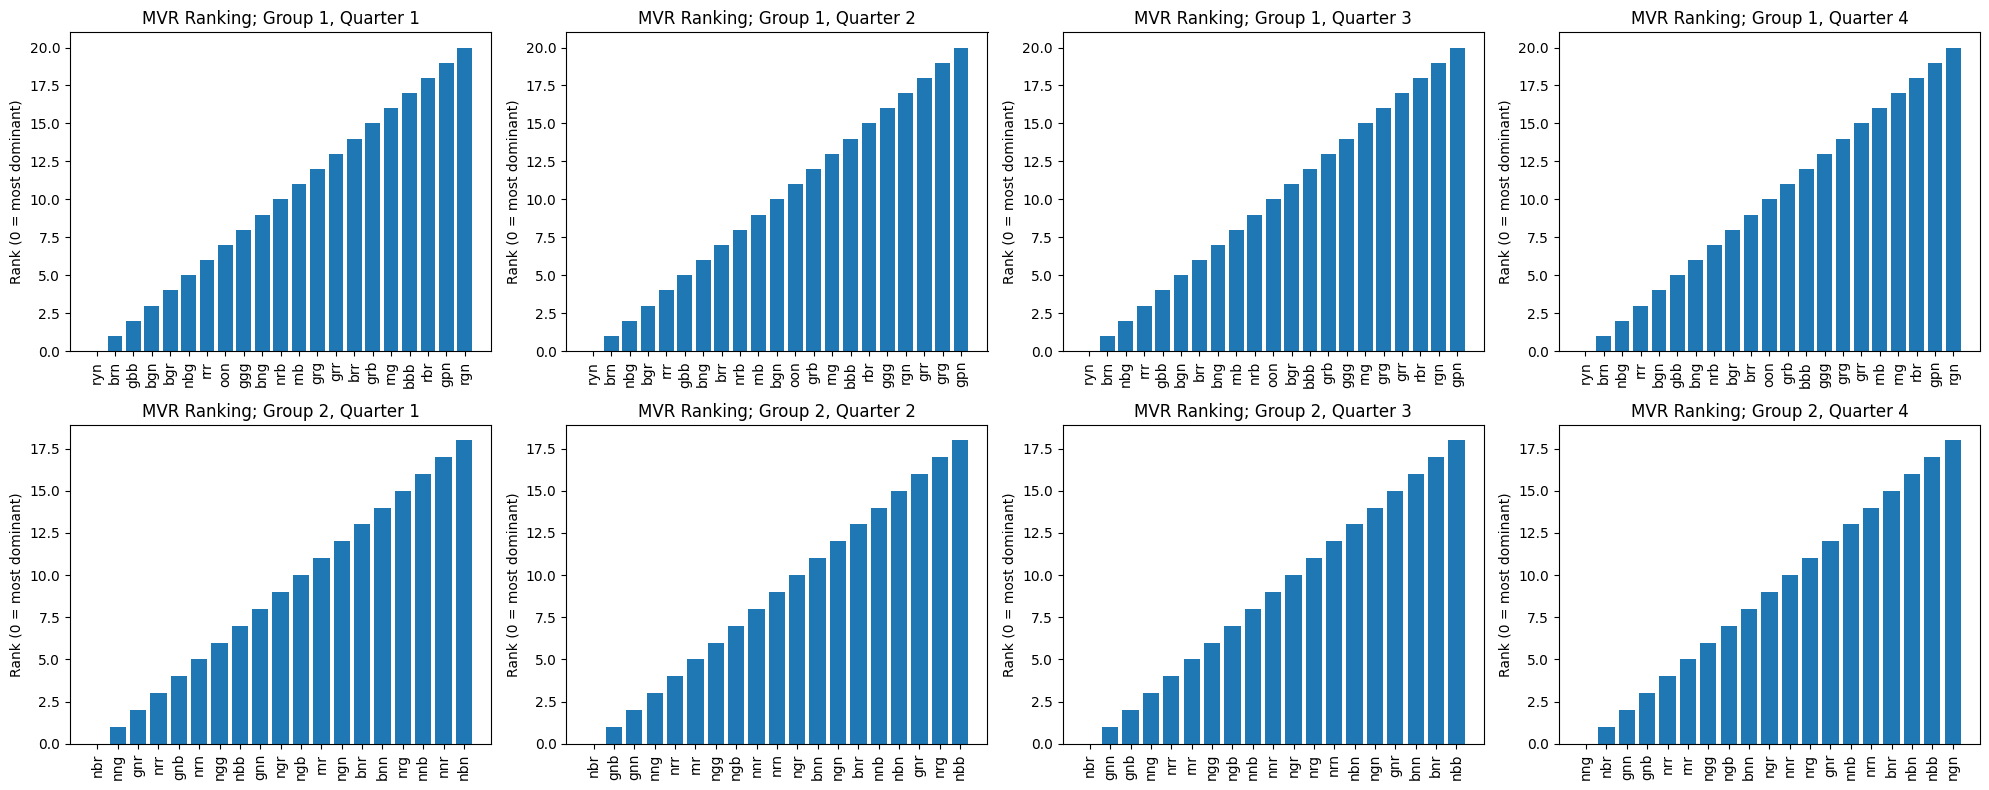

In [ ]:
import matplotlib.pyplot as plt

# Draw on a given axis instead of making its own figure.
def plot_mvr_barplot(group, quarter, ax=None):
    data  = results_mvr[(group, quarter)]
    order = data['order']
    
    if ax is None:
        ax = plt.gca()   # Fallback to current axis if none passed.

    ax.bar(range(len(order)), range(len(order)), tick_label=order)
    ax.set_xticklabels(order, rotation=90)
    ax.set_ylabel("Rank (0 = most dominant)")
    ax.set_title(f"MVR Ranking; Group {group}, Quarter {quarter}")


def plot_all_mvr_subplots():
    # 2 rows (groups 1,2) x 4 columns (quarters 1..4).
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))

    for g in [1, 2]:
        for q in [1, 2, 3, 4]:
            ax = axes[g - 1, q - 1]
            plot_mvr_barplot(g, q, ax=ax)

    plt.tight_layout()
    plt.show()

plot_all_mvr_subplots()


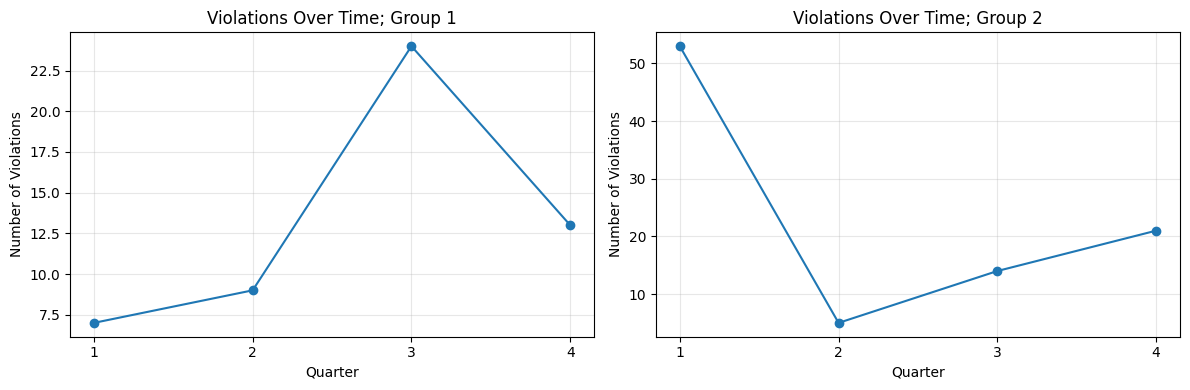

In [ ]:
def plot_violation_trend(group, ax=None):
    vals = []
    for q in [1, 2, 3, 4]:
        V = results_mvr[(group, q)]['violations']
        vals.append(V)

    if ax is None:
        ax = plt.gca()

    ax.plot([1, 2, 3, 4], vals, marker='o')
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xlabel("Quarter")
    ax.set_ylabel("Number of Violations")
    ax.set_title(f"Violations Over Time; Group {group}")
    ax.grid(True, alpha=0.3)

# Compile.
def plot_all_violation_trends():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for g in [1, 2]:
        plot_violation_trend(g, ax=axes[g - 1])

    plt.tight_layout()
    plt.show()

plot_all_violation_trends()


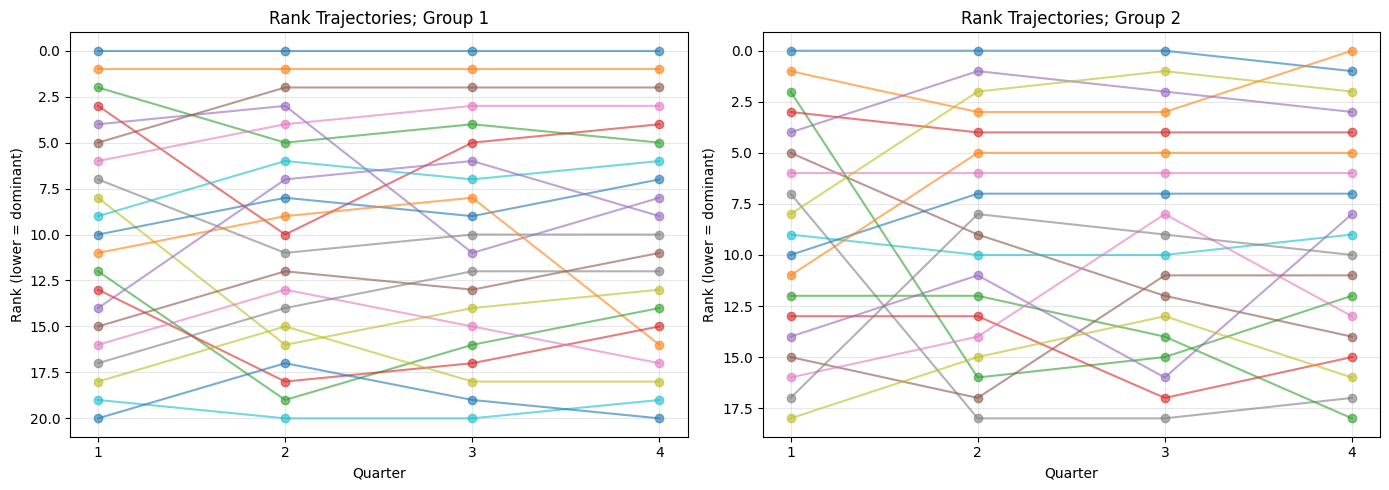

In [ ]:
import matplotlib.pyplot as plt

def plot_rank_trajectories(group, ax=None):
    tmp = df_mvr[df_mvr['group'] == group]

    if ax is None:
        ax = plt.gca()

    for bird in tmp['individual'].unique():
        sub = tmp[tmp['individual'] == bird].sort_values('quarter')
        ax.plot(sub['quarter'], sub['rank'], marker='o', alpha=0.6)

    ax.invert_yaxis()  # rank 0 at top
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xlabel("Quarter")
    ax.set_ylabel("Rank (lower = dominant)")
    ax.set_title(f"Rank Trajectories; Group {group}")
    ax.grid(True, alpha=0.3)

# Compile.
def plot_all_rank_trajectories():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for g in [1, 2]:
        plot_rank_trajectories(g, ax=axes[g - 1])

    plt.tight_layout()
    plt.show()

plot_all_rank_trajectories()

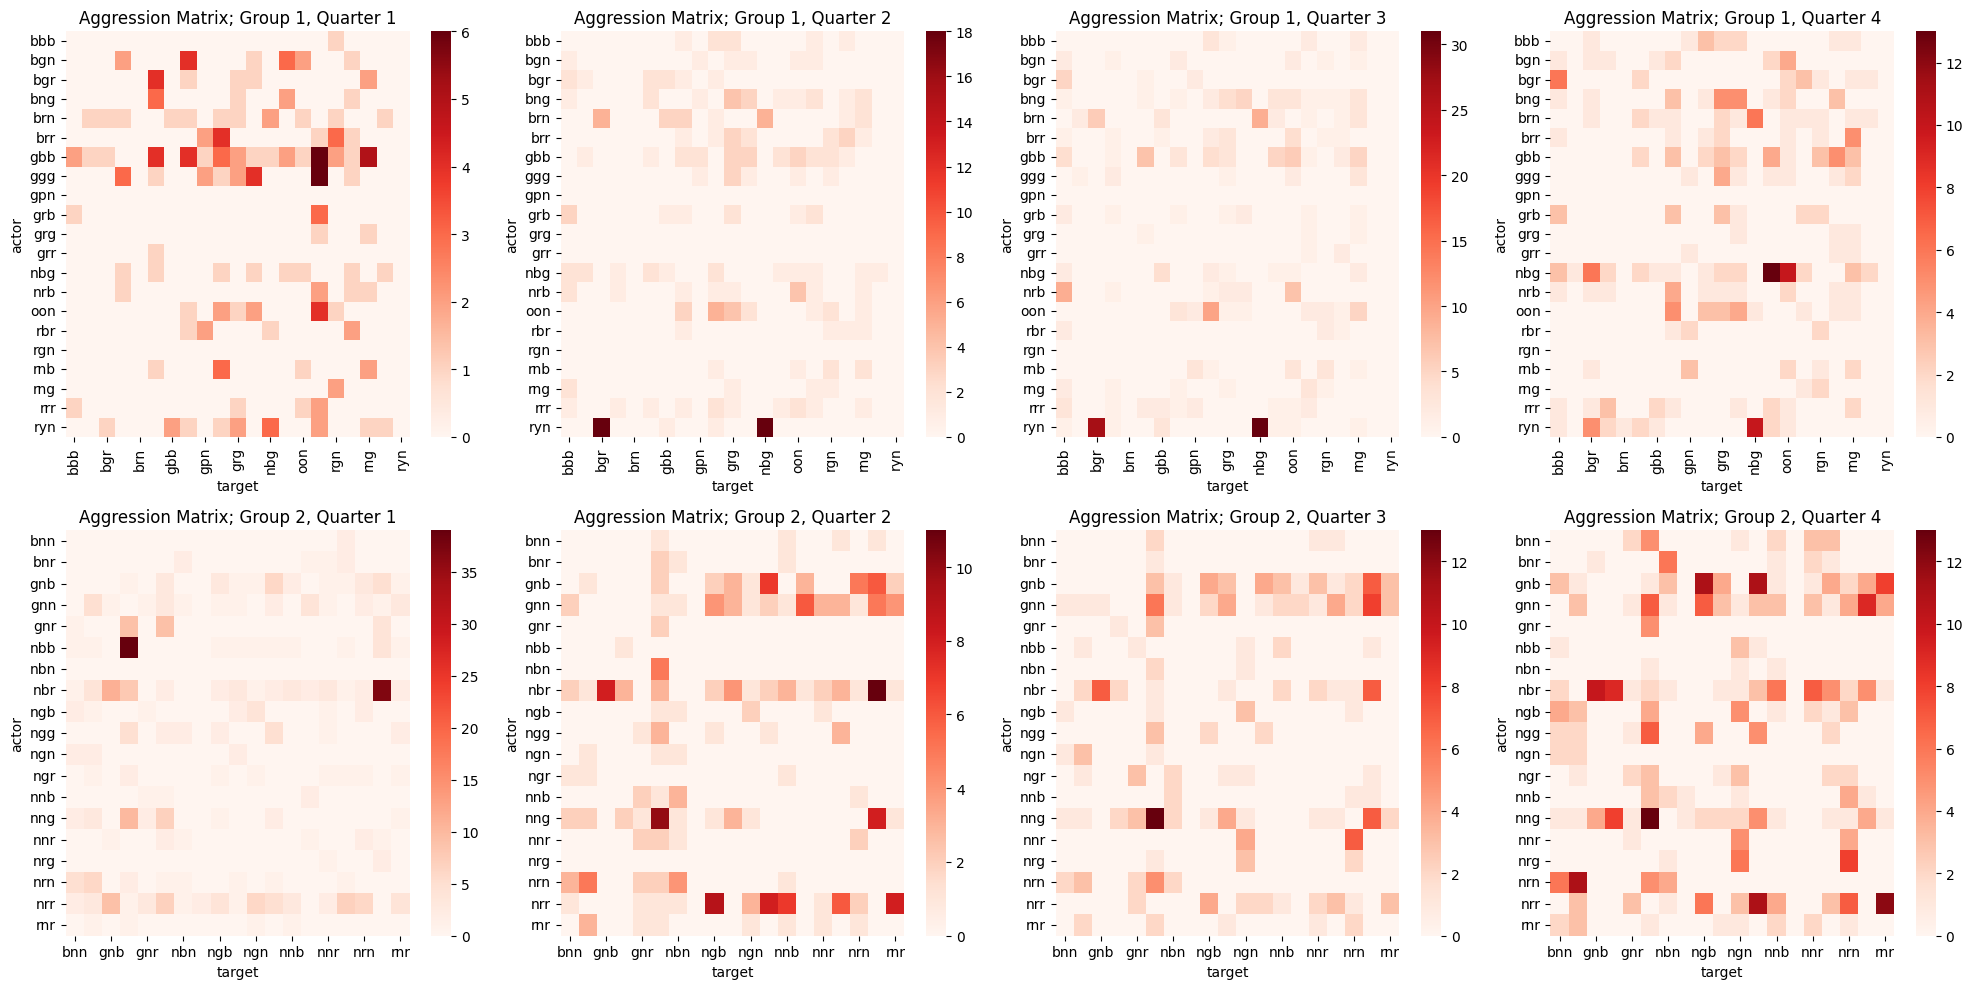

In [ ]:
import seaborn as sns

def plot_heatmap(group, quarter, ax=None):
    A = results_mvr[(group, quarter)]['A']

    if ax is None:
        ax = plt.gca()

    sns.heatmap(A, cmap="Reds", ax=ax, cbar=True)
    ax.set_title(f"Aggression Matrix; Group {group}, Quarter {quarter}")

# Compile.
def plot_all_heatmaps():
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    for g in [1, 2]:
        for q in [1, 2, 3, 4]:
            ax = axes[g - 1, q - 1]
            plot_heatmap(g, q, ax=ax)

    plt.tight_layout()
    plt.show()

plot_all_heatmaps()


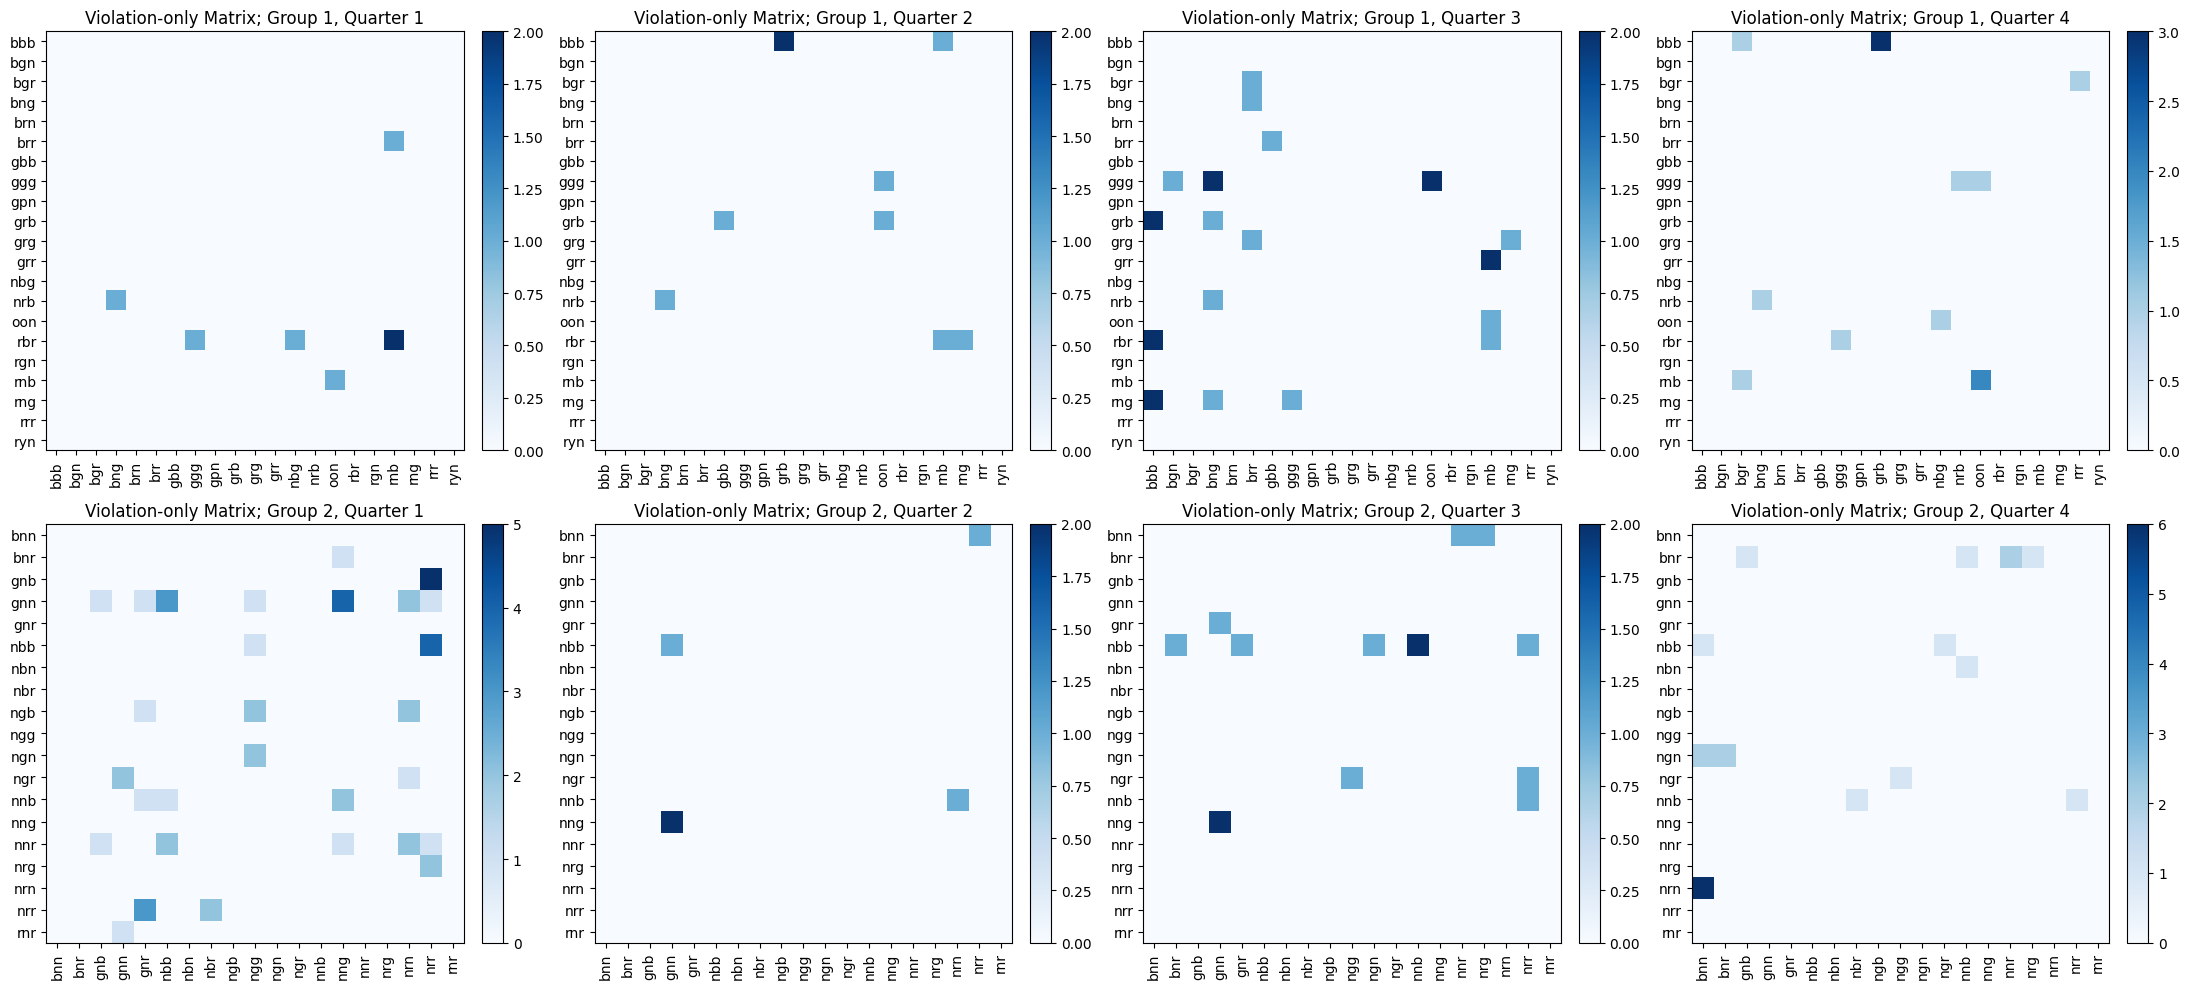

In [ ]:
def plot_violation_matrix(group, quarter, ax=None):
    data  = results_mvr[(group, quarter)]
    order = data['order']
    A     = data['A']

    # Compute ranking index.
    rank = {node: i for i, node in enumerate(order)}

    # Make the violation-only matrix.
    Vmat = A.copy()
    for i in A.index:
        for j in A.columns:
            if not (rank[i] > rank[j]):   # if it's NOT a violation.
                Vmat.loc[i, j] = 0

    if ax is None:
        ax = plt.gca()

    im = ax.imshow(Vmat.values, cmap='Blues', aspect='auto')
    ax.set_xticks(range(len(Vmat.columns)))
    ax.set_xticklabels(Vmat.columns, rotation=90)
    ax.set_yticks(range(len(Vmat.index)))
    ax.set_yticklabels(Vmat.index)
    ax.set_title(f"Violation-only Matrix; Group {group}, Quarter {quarter}")

    # Add colorbar to the figure, anchored to this axis.
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Compile.
def plot_all_violation_matrices():
    fig, axes = plt.subplots(2, 4, figsize=(22, 10))

    for g in [1, 2]:
        for q in [1, 2, 3, 4]:
            ax = axes[g - 1, q - 1]
            plot_violation_matrix(g, q, ax=ax)

    plt.tight_layout()
    plt.show()

plot_all_violation_matrices()